# Partie 1 : Code pour la modélisation

In [126]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [295]:
def generer_sorties(nb, x_max, y_max):
    # Générer aléatoirement les positions des sorties
    sorties = np.empty((nb, 4), dtype=object)
    for i in range(nb):
        # Choisir aléatoirement si la sortie est sur un mur horizontal ou vertical
        is_horizontal = random.choice([True, False])
        if is_horizontal:
            x = random.choice([0, x_max])  # La sortie est sur un mur horizontal
            y = random.randint(0, y_max)
        else:
            x = random.randint(0, x_max)
            y = random.choice([0, y_max])  # La sortie est sur un mur vertical
        sorties[i, 0] = i # identifiant de la sortie
        sorties[i, 1] = x # coordonnée x de la sortie
        sorties[i, 2] = y # coordonnée y de la sortie
        sorties[i, 3] = random.randint(2, 3) # temps de passage : temps nécessaire pour chaque personne passe
    return sorties

def generer_people(nb,x_max,y_max):
    #x_max, y_max = dimension de l'espace
    people = np.empty((nb,6), dtype=object) # 2 niveau
    people_nv_faible = np.empty((nb,6), dtype=object) # que des niveaux faibles
    people_nv_eleve = np.empty((nb,6), dtype=object) # que des niveaux élevées
    for i in range(nb):
        # Générer aléatoirement les coordonnées des x et des y
        x = random.randint(0,x_max)
        y = random.randint(0,y_max)
        x_faible = random.randint(0,x_max)
        y_faible = random.randint(0,y_max)
        x_eleve = random.randint(0,x_max)
        y_eleve = random.randint(0,y_max)
        
        # Générer aléatoirement le niveau de perception du danger(faible ou élevé)
        nv_perception = random.choice(['faible','élevé'])
        nv_perception_faible = 'faible'
        nv_perception_eleve = 'élevé'
        
        # Générer aléatoirement la vitesse en fonction du niveau de perception
        if nv_perception == 'faible':
            vitesse = np.round(random.uniform(0.3, 0.7),1) # Vitesse faible pour people
        else:
            vitesse = np.round(random.uniform(0.9, 1.3),1) # Vitesse élevéé pour people
        
        vitesse_faible = np.round(random.uniform(0.3, 0.8),1) # Vitesse faible pour people_nv_faible
        vitesse_eleve = np.round(random.uniform(1.0, 1.6),1) # Vitesse élevéé pour people_nv_eleve

        
        # Initialiser la colonne "sortie" à False
        sortie = False # La personne n'est pas encore sortie
        
        people[i, 0],people_nv_faible[i,0],people_nv_eleve[i,0] = i,i,i # Numéro d'identification
        people[i, 1],people_nv_faible[i,1],people_nv_eleve[i,1] = x, x_faible, x_eleve # Coordonnée x
        people[i, 2],people_nv_faible[i,2],people_nv_eleve[i,2] = y, y_faible, y_eleve # Coordonnée y
        people[i, 3],people_nv_faible[i,3],people_nv_eleve[i,3] = nv_perception, nv_perception_faible, nv_perception_eleve # Niveau de perception
        people[i, 4],people_nv_faible[i,4],people_nv_eleve[i,4] = vitesse, vitesse_faible, vitesse_eleve # Vitesse
        people[i, 5],people_nv_faible[i,5],people_nv_eleve[i,5] = sortie,sortie,sortie # True si la personne est sortie, False sinon
    return people, people_nv_faible, people_nv_eleve

In [296]:
def sortiePlusProche(pos,sorties):
    # pos : Coordonnées de la personnne
    # sorties : une liste de coordonnées des sorties
    # Retourne la sortie plus proche et son temps de passage
    coord_sorties = sorties[:,1:3]
    d = coord_sorties - pos
    d = d.astype(float)
    norm = np.linalg.norm(d, axis=1)
    indice_sortie = np.argmin(norm)
    sortie_proche = sorties[indice_sortie]
    return sortie_proche


def direction(pos,sorties):
    sortie_proche = sortiePlusProche(pos,sorties)
    coord_sortie = sortie_proche[1:3]
    d = coord_sortie-pos
    d = d.astype(float)
    norm = np.linalg.norm(d)
    return d / norm if norm != 0 else 0


def step(pos,sorties,v,dt): 
    # déplacement de la personne en fonction de la vitesse et du pas de temps
    dir = direction(pos,sorties)
    return v*dt*np.atleast_1d(dir)


def new_position(pos, sorties, v, dt):
    # Mettre à jour la nouvelle position en fonction de la vitesse et du pas de temps
    new_step = step(pos,sorties,v,dt)
    return pos + new_step


def est_sortie(pos, sortie_proche, v, dt):
    # Déterminer si la personne arrive à la sortie
    coord_sortie = sortie_proche[1:3]
    marge_sortie = v * dt * 0.5 # Marge de sécurité pour déterminer si la personne est sortie
    norm = np.linalg.norm(pos - coord_sortie) # Distance entre la position actuelle et la sortie
    return norm <= marge_sortie


def update_status(l_steps, i, j, v, dt, sorties, sortie_proche, sortie_personnes, temps_sortie):
    # Mettre à jours les informations de la personne une fois elle est sortie
    id_sortie = sortie_proche[0]
    temps_passage = sortie_proche[3]
    pos = l_steps[i, j, 1:3]
    new_pos = new_position(pos, sorties, v, dt) # Nouvelle position de la personne
    if sortie_personnes[id_sortie] == -1:
        l_steps[i + 1:, j, 5] = True
        sortie_personnes[id_sortie] = j
        temps_sortie[id_sortie] = temps_passage
    else:
        l_steps[i + 1, j, :5] = l_steps[i, j, :5]

def update_times(temps_sortie, sortie_personnes):
    # Gérer le temps de passage pour chaque sortie
    for sortie_id in range(len(sortie_personnes)):
        if temps_sortie[sortie_id] > 0: 
            temps_sortie[sortie_id] = temps_sortie[sortie_id] - 1
            if temps_sortie[sortie_id]==0 : # Vérifier si la sortie est libre maintenant
                # Réinitialiser les valeurs en -1
                temps_sortie[sortie_id] = -1
                sortie_personnes[sortie_id] = -1

In [297]:
def step_people(people,sorties,dt,t_max):
    temps = np.arange(0,t_max+dt,dt)
    n_step=len(temps) # Nombre de pas
    
    l_steps = np.empty((n_step, len(people), 6), dtype=object) # liste des steps
    l_steps[0]=people
    l_steps[:, :, 0] = people[:, 0] # Numéro d'identification inchangé
    l_steps[:, :, 3] = people[:, 3] # Niveau de perception inchangé
    l_steps[:, :, 4] = people[:, 4] # Vitesse inchangée
    
    sortie_personnes = np.full(len(sorties),-1) # l'identifiant de la personne en train de sortie pour chaque sortie
    temps_sortie = np.full(len(sorties),-1) # temps reste pour chaque sortie

    temps_sortie_personnes = []  # Liste pour stocker les temps de parcours de chaque personne
    
    for i in range(n_step-1):
        for j in range(len(people)):
            # Vérifier si la personne est déjà sortie
            if l_steps[i, j, 5]: # Si la personne est déjà sortie, on passe à la personne suivante
                continue
            
            pos = l_steps[i, j, 1:3] # Position actuelle de la personne
            v = l_steps[i, j, 4] # Vitesse individuelle de la personne j
            new_pos = new_position(pos, sorties, v, dt) # Nouvelle position de la personne
            sortie_proche = sortiePlusProche(new_pos,sorties) # Choisir la sortie la plus proche pour la personne j
                        
            if est_sortie(new_pos, sortie_proche, v, dt):
                update_status(l_steps, i, j, v, dt, sorties, sortie_proche, sortie_personnes, temps_sortie)
                l_steps[i + 1:, j, 1:3] = new_pos
                temps_parcours = temps[i]  # Calcul du temps de parcours pour personne j
                temps_sortie_personnes.append(temps_parcours)  # Stocker le temps de parcours
            else:
                l_steps[i + 1, j, 1:3] = new_pos # Nouvelle position
                l_steps[i + 1, j, 5] = l_steps[i, j, 5] # Sortie inchangée
        update_times(temps_sortie, sortie_personnes)
        
        if np.all(l_steps[i, :, 5] == True): # Vérifier si tout le monde est sorti
            temps_parcours_moyen = np.mean(temps_sortie_personnes)
            print("A t = ",i,"s, tout le monde est évacué avec succès")
            return l_steps, temps[i], temps_parcours_moyen
    
    temps_parcours_moyen = np.mean(temps_sortie_personnes)
    return l_steps, t_max, temps_parcours_moyen

In [298]:
def evacuation(step, sorties):
    # Retourne le nombre de personnes évacuées
    evacuated = [] # Liste pour suivre les personnes évacuées
    people = step 
    for person in step:
        pos = np.array([person[1], person[2]])
        sortie = sortiePlusProche(pos,sorties)

        # Vérifier si la personne a atteint la sortie
        if person[5]: # Si la colonne "sortie" est True
            evacuated.append(person[0]) # Ajouter le numéro d'identification de la personne dans la liste

    # Retirer les personnes évacuées de la liste_step
    people = [person for person in people if person[0] not in evacuated] # Liste des personnes non évacuées

    # Si tous les personnes sont évacuées
    if len(people) == 0:
        print("Tous les individus sont évacués")
    # Si au moins une personne qui n'est pas évacuées
    else :
        print("Nombre d'individus non évacués:", len(people))
        #print("\nListe des individus non évacués:\n", people)
    
    return len(evacuated)

# Partie 2 : Visualiser la simulation

In [299]:
# Définir les paramètres
x_max = 30 #en m
y_max = 30 #en m
nb_pers = 60
nb_sorties = 2
dt = 1 #en s
tmax = 180 #en s
nframe = tmax+1

# Générer les sorties et les personnes
sorties = generer_sorties(nb_sorties, x_max, y_max)
people, people_nv_faible, people_nv_eleve = generer_people(nb_pers,x_max,y_max)

In [301]:
# Résultats de l'évacuation
# Liste_step : Liste des étapes de simulation avec niveau différent
liste_steps, t_fin, t_moy = step_people(people,sorties,dt,tmax)
print("temps pour évacuer = ",t_fin," (tous les niveaux)")
evacuated = evacuation(liste_steps[-1],sorties)
print("nombre de personnes évacuées = ",evacuated)
print(t_fin, t_moy)

A t =  111 s, tout le monde est évacué avec succès
temps pour évacuer =  111  (tous les niveaux)
Tous les individus sont évacués
nombre de personnes évacuées =  60
111 46.225157232704404


In [302]:
# liste_steps_f : Liste des étapes de simulation avec niveau faible
liste_steps_f, t_fin_f, t_moy_f = step_people(people_nv_faible,sorties,dt,tmax)
print("temps pour évacuer = ",t_fin_f," (niveau faible)")
evacuated_f = evacuation(liste_steps_f[-1],sorties)
print("nombre de personnes évacuées = ",evacuated_f)
print(t_fin_f, t_moy_f)

A t =  106 s, tout le monde est évacué avec succès
temps pour évacuer =  106  (niveau faible)
Tous les individus sont évacués
nombre de personnes évacuées =  60
106 47.15088282504013


In [303]:
# liste_steps_e : Liste des étapes de simulation avec niveau élevé
liste_steps_e, t_fin_e, t_moy_e = step_people(people_nv_eleve,sorties,dt,tmax)
print("temps pour évacuer = ",t_fin_e," (niveau élevé)")
evacuated_e = evacuation(liste_steps_e[-1],sorties)
print("nombre de personnes évacuées = ",evacuated_e)
print(t_fin_e, t_moy_e)

A t =  98 s, tout le monde est évacué avec succès
temps pour évacuer =  98  (niveau élevé)
Tous les individus sont évacués
nombre de personnes évacuées =  60
98 34.294310722100654


## Animation

In [292]:
# Créez la figure
fig1, ax1 = plt.subplots(figsize=(6,5))
plt.xlim(0, x_max)
plt.ylim(0, y_max)
ax1.set_aspect('equal')

# Créer les sorties
ax1.scatter(sorties[:,1],sorties[:,2],color='green',marker='s', s=150)
for i, (x, y) in enumerate(sorties[:, 1:3]): # Ajouter des étiquettes aux sorties
    ax1.annotate(f'Sortie {i+1}', (x, y), xytext=(0, 20), textcoords='offset points',ha="center", va="center", size=10, bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", ec="green", lw=2))

# Initialiser les position et les couleurs des personnes
x1 = people[:,1] # Position initiale x
y1 = people[:,2] # Position initiale y
colors = {'faible': 'blue', 'élevé': 'red'} # Couleurs des personnes en fonction de leur niveau de perception

# Créer l'objet de la personne avec les positions et couleurs initiales
person1 = ax1.scatter(x1, y1, color=[colors[p[3]] for p in people], marker='o', s=50)

# Fonction pour mettre à jours les positions
def update_point(frame) :
    global liste_steps
    ax1.set_title('Time = {} s'.format(frame))
    newx = liste_steps[frame,:,1]
    newy = liste_steps[frame,:,2]
    data = np.stack((newx, newy), axis=-1)
    person1.set_offsets(data)

# Créer puis afficher l'animation
anim1 = animation.FuncAnimation(fig1, update_point, t_fin, interval = 700, repeat=False)
anim1.save('scatter1.gif', writer='pillow')  # Générer le fichier GIF
plt.close()
HTML('<img src="scatter1.gif" />')

## Trajectoire

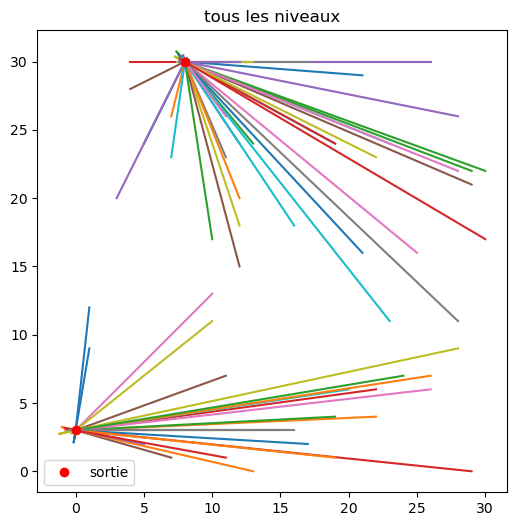

In [293]:
plt.figure(figsize=(10,6))

def plot_xy(nb_pers,liste_steps):
    pos_x = []
    pos_y = []
    for i in range(nb_pers):
        pos_x = liste_steps[:,i,1]
        pos_y = liste_steps[:,i,2]
        plt.plot(pos_x,pos_y)

#plt.subplot(1,3,1)
plot_people = plot_xy(nb_pers,liste_steps) # Plot personnes
plot_sortie1 = plt.plot(sorties[:,1],sorties[:,2],"ro",label="sortie") # Plot sorties
plt.title("tous les niveaux")
plt.legend()
plt.axis("scaled")
plt.savefig("Cas3_4sortie")

In [ ]:
plt.subplot(1,3,2)
plot_sortie_f = plt.plot(sorties[:,1],sorties[:,2],"ro",label="sortie") # Plot sorties
plot_people_f = plot_xy(nb_pers,liste_steps_f) # Plot personnes
plt.title("niveau faible")
plt.legend()

In [ ]:
plt.subplot(1,3,3)
plot_sortie_e = plt.plot(sorties[:,1],sorties[:,2],"ro",label="sortie") # Plot sorties
plot_people_e = plot_xy(nb_pers,liste_steps_e) # Plot personnes
plt.title("niveau élevé")
plt.legend()
plt.tight_layout()

plt.show()

# Partie 3 : Analyse

## Taux d'évacuation succès en fonction du temps (pour unité de temps)

In [23]:
#taux de succès : pourcentage d'individus évacués avec succès par rapport au nombre total
def success_rate(step):
    # step = liste des positions pour un seul step
    nb_evacuated = np.count_nonzero(step[:,5])
    nb_pers_total = len(step)
    return nb_evacuated/nb_pers_total*100

taux_succes = success_rate(liste_steps[-1])
print(taux_succes)

100.0


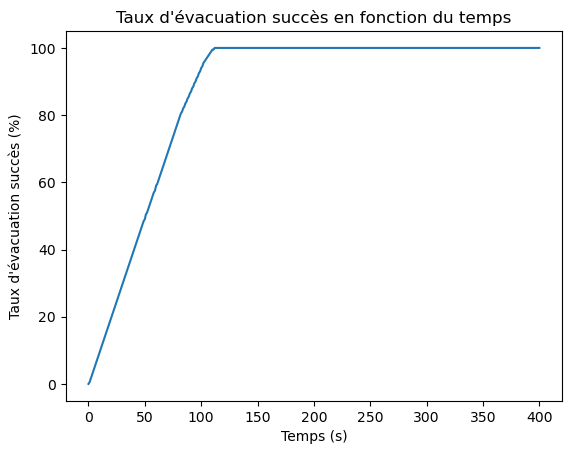

In [113]:
#taux d'évacuation succès en fonction du temps (pour unité de temps) -> commenter l'efficacité d'évacuation
def rate_evacuation_temps (liste_steps):
    # liste_steps contient toutes les étapes de simulation
    #retourner la liste contenant le taux d'évacuation pour chaque pas de temps
    res = [] # Liste de retour
    for step in liste_steps:
        rate = success_rate(step)
        res.append(rate)
    return res   

#plt.figure(figsize=(5,5))
x = np.arange(0,len(liste_steps),1)
y = rate_evacuation_temps(liste_steps)
plt.plot(x,y)
plt.xlabel("Temps (s)")
plt.ylabel("Taux d'évacuation succès (%)")
plt.title("Taux d'évacuation succès en fonction du temps")
plt.savefig("Cas3_4sortie_taux_evac_temps")
plt.show()

# On étudie le temps d'évacuation / moyen et le taux d'évacuation en fonction de plusieurs paramètres
- Le temps d'évacuation : le temps de parcours total
- Le temps moyen  : temps mis par une personne pour atteindre une sortie depuis son point de départ
- Le taux d'évacuation : pourcentage de nombre de personnes évacuées par rapport au nombre total

# I. En fonction de la densité de population

In [134]:
nb_personnes = np.arange(10,101,10)
print(nb_personnes)

[ 10  20  30  40  50  60  70  80  90 100]


### I. 1. Temps d'évacuation total/moyen en fonction de densité de population

A t =  49 s, tout le monde est évacué avec succès
A t =  48 s, tout le monde est évacué avec succès
A t =  57 s, tout le monde est évacué avec succès
A t =  88 s, tout le monde est évacué avec succès
A t =  89 s, tout le monde est évacué avec succès
A t =  115 s, tout le monde est évacué avec succès
A t =  107 s, tout le monde est évacué avec succès
A t =  146 s, tout le monde est évacué avec succès
A t =  148 s, tout le monde est évacué avec succès
A t =  161 s, tout le monde est évacué avec succès


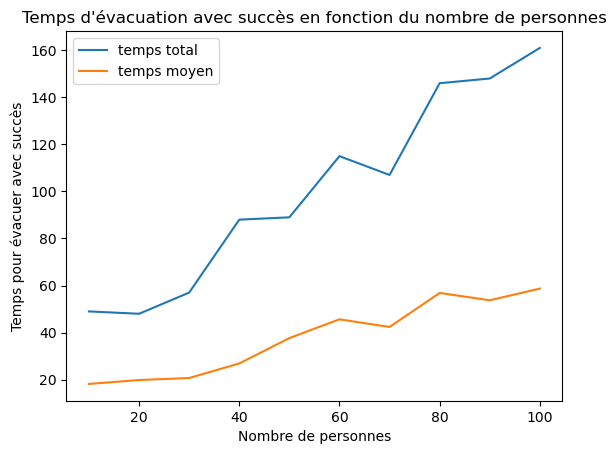

In [304]:
#temps d'évacuation total/moyen en fonction de nombres de personnes
def temps_evacuer_nbPers(nb_personnes):
    temps_evac_total = []
    temps_evac_moyen = []
    for nb in nb_personnes:
        p, _, _ = generer_people(nb,x_max,y_max)
        _, t_total, t_moyen = step_people(p,sorties,dt,180)
        temps_evac_total.append(t_total)
        temps_evac_moyen.append(t_moyen)
    return temps_evac_total, temps_evac_moyen
temps_total, temps_moyen = temps_evacuer_nbPers(nb_personnes)

plt.plot(nb_personnes, temps_total, label="temps total")
plt.plot(nb_personnes, temps_moyen, label="temps moyen")
plt.xlabel("Nombre de personnes")
plt.ylabel("Temps pour évacuer avec succès")
plt.title("Temps d'évacuation avec succès en fonction du nombre de personnes")
#plt.axis("scaled")
plt.legend()
plt.show()

### I. 2. Taux d'évacuation en fonction de la densité de personnes (pour 120 secondes)

A t =  27 s, tout le monde est évacué avec succès
A t =  60 s, tout le monde est évacué avec succès
A t =  90 s, tout le monde est évacué avec succès
A t =  63 s, tout le monde est évacué avec succès
A t =  97 s, tout le monde est évacué avec succès
A t =  111 s, tout le monde est évacué avec succès
A t =  119 s, tout le monde est évacué avec succès


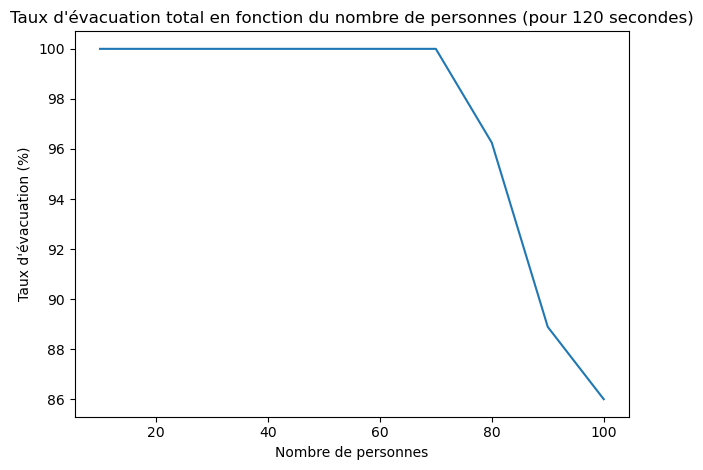

In [312]:
def taux_evac_nbPers(nb_personnes):
    liste_taux = []
    tmax = 120
    for nb in nb_personnes:
        p, _, _ = generer_people(nb,x_max,y_max)
        liste, t_total, t_moyen = step_people(p,sorties,dt,tmax)
        taux = success_rate(liste[-1])
        liste_taux.append(taux)
    return liste_taux

taux_en_fonction_nb = taux_evac_nbPers(nb_personnes)

plt.plot(nb_personnes, taux_en_fonction_nb)
plt.xlabel("Nombre de personnes")
plt.ylabel("Taux d'évacuation (%)")
plt.title("Taux d'évacuation total en fonction du nombre de personnes (pour 120 secondes)")
plt.tight_layout()
plt.show()

# II. En fonction du niveau de perception (la vitesse)

### II. 1. Temps d'évacuation total en fonction du niveau de perception

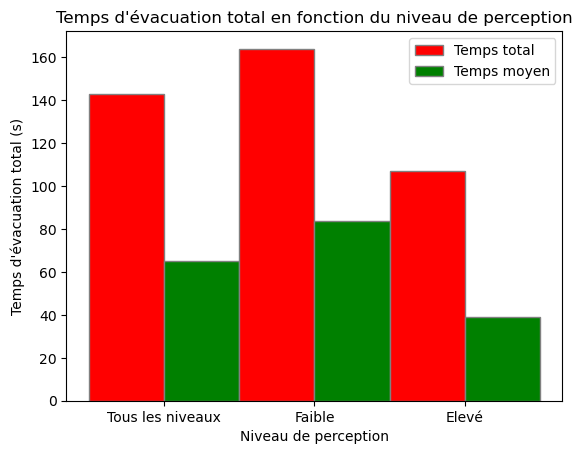

In [242]:
# Positions des barres sur l'axe des x
bar_width = 0.3 # Largeur des barres
r1 = np.arange(0,6*bar_width,bar_width)

x_ticks = ['Tous les niveaux','Faible', 'Elevé']

# Création de l'histogramme
plt.bar(r1[0], t_fin, color='r', width=bar_width, edgecolor='grey', label='Temps total')
plt.bar(r1[1], t_moy, color='g', width=bar_width, edgecolor='grey', label='Temps moyen')
plt.bar(r1[2], t_fin_f, color='r', width=bar_width, edgecolor='grey')
plt.bar(r1[3], t_moy_f, color='g', width=bar_width, edgecolor='grey')
plt.bar(r1[4], t_fin_e, color='r', width=bar_width, edgecolor='grey')
plt.bar(r1[5], t_moy_e, color='g', width=bar_width, edgecolor='grey')

# Ajout de titres et de légendes
plt.xlabel("Niveau de perception")
plt.ylabel("Temps d'évacuation total (s)")
plt.title("Temps d'évacuation total en fonction du niveau de perception")
plt.xticks([0.15,0.75,1.35], x_ticks)
plt.legend()
plt.show()

### II. 2. Taux d'évacuation en fonction du niveau de perception

A t =  110 s, tout le monde est évacué avec succès


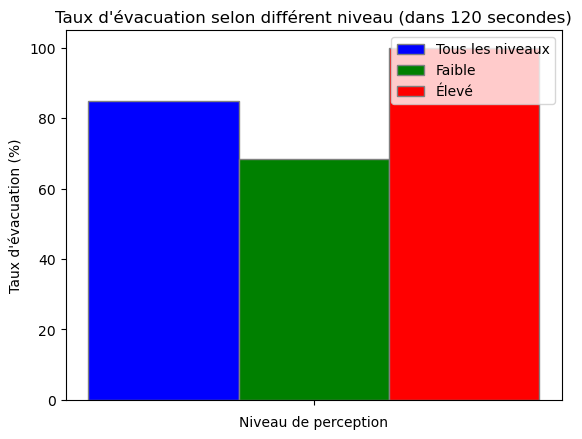

In [246]:
time_max = 120
nb_people = 60
p, p_faible , p_eleve = generer_people(nb_people,x_max,y_max)
#print(p, p_faible , p_eleve)
liste_p, _, _= step_people(p,sorties,dt,time_max)
liste_p_faible, _, _= step_people(p_faible,sorties,dt,time_max)
liste_p_eleve, _, _= step_people(p_eleve,sorties,dt,time_max)
taux_nv = success_rate(liste_p[-1])
taux_p_faible = success_rate(liste_p_faible[-1])
taux_p_eleve = success_rate(liste_p_eleve[-1])

# Positions des barres sur l'axe des x
bar_width = 0.3 # Largeur des barres
r1 = np.arange(1)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Création de l'histogramme
plt.bar(r1, taux_nv, color='b', width=bar_width, edgecolor='grey', label='Tous les niveaux')
plt.bar(r2, taux_p_faible, color='g', width=bar_width, edgecolor='grey', label='Faible')
plt.bar(r3, taux_p_eleve, color='r', width=bar_width, edgecolor='grey', label='Élevé')

# Ajout de titres et de légendes
plt.xlabel("Niveau de perception")
plt.ylabel("Taux d'évacuation (%)")
plt.title("Taux d'évacuation selon différent niveau (dans 120 secondes)")
plt.xticks([r + bar_width for r in range(1)], [''])
plt.legend()
plt.show()

# III. En fonction du nombre de sorties

In [248]:
liste_nombre_sorties = np.arange(1,5,1)

### III. 1. Temps d'évacuation en fonction du nombre de sortie

A t =  176 s, tout le monde est évacué avec succès
A t =  151 s, tout le monde est évacué avec succès
A t =  121 s, tout le monde est évacué avec succès
A t =  90 s, tout le monde est évacué avec succès


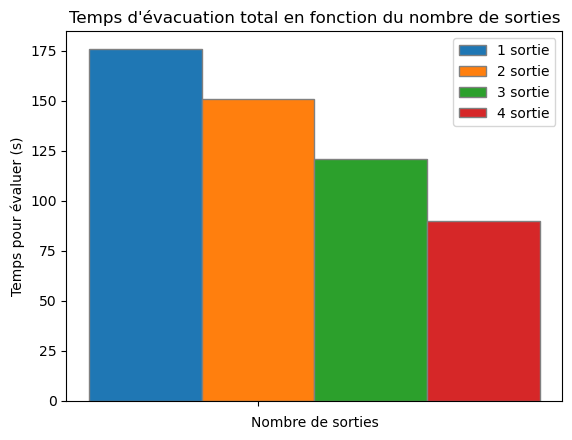

In [256]:
def temps_nbSorties(liste_nombre_sorties):
    nb_pers = 60
    tmax = 250
    temps_total = []
    for i in range(len(liste_nombre_sorties)):
        sorties = generer_sorties(liste_nombre_sorties[i], x_max, y_max)
        p, _, _ = generer_people(nb_pers,x_max,y_max)
        _, t_total, _ = step_people(p,sorties,dt,tmax)
        temps_total.append(t_total)
    return temps_total

liste_temps_total = temps_nbSorties(liste_nombre_sorties)

# Positions des barres sur l'axe des x
bar_width = 0.3 # Largeur des barres
r1 = np.arange(0,len(liste_nombre_sorties)*bar_width,bar_width)

# Création de l'histogramme
for i in range(len(r1)):
    label = str(liste_nombre_sorties[i])+" sortie"
    plt.bar(r1[i], liste_temps_total[i], width=bar_width, edgecolor='grey', label=label)

# Ajout de titres et de légendes
plt.xlabel("Nombre de sorties")
plt.ylabel("Temps pour évaluer (s)")
plt.title("Temps d'évacuation total en fonction du nombre de sorties")
plt.xticks([r + bar_width for r in range(1)],[''])
plt.legend()
plt.show()

### III. 2. Taux d'évacuation en fonction du nombre de sortie

A t =  41 s, tout le monde est évacué avec succès


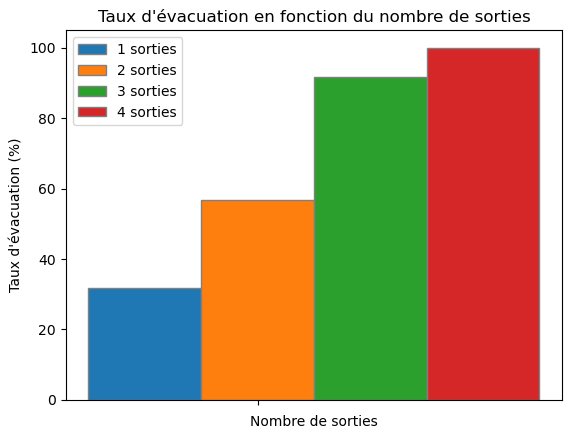

In [323]:
def taux_nbSorties(liste_nombre_sorties):
    nb_pers = 60
    tmax = 60
    liste_taux = []
    for i in range(len(liste_nombre_sorties)):
        sorties = generer_sorties(liste_nombre_sorties[i], x_max, y_max)
        p, _, _ = generer_people(nb_pers,x_max,y_max)
        liste, _, _ = step_people(p,sorties,dt,tmax)
        taux = success_rate(liste[-1])
        liste_taux.append(taux)
    return liste_taux

liste_taux_sorties = taux_nbSorties(liste_nombre_sorties)

# Positions des barres sur l'axe des x
bar_width = 0.3 # Largeur des barres
r1 = np.arange(0,len(liste_nombre_sorties)*bar_width,bar_width)

# Création de l'histogramme
for i in range(len(r1)):
    label = str(liste_nombre_sorties[i])+" sorties"
    plt.bar(r1[i], liste_taux_sorties[i], width=bar_width, edgecolor='grey', label=label)

# Ajout de titres et de légendes
plt.xlabel("Nombre de sorties")
plt.ylabel("Taux d'évacuation (%)")
plt.title("Taux d'évacuation en fonction du nombre de sorties (dans 60s)")
plt.xticks([r + bar_width for r in range(1)],[''])
plt.legend()
plt.show()

In [ ]:
# Version avant reduire
def step_people_copy(people,sorties,dt,t_max):
    temps = np.arange(0,t_max+dt,dt)
    n_step=len(temps) # Nombre de pas
    l_steps = np.empty((n_step, len(people), 6), dtype=object) # liste des steps
    l_steps[0]=people
    sortie_personnes = np.full(len(sorties),-1) # l'identifiant de la personne en train de sortie pour chaque sortie
    temps_sortie = np.full(len(sorties),-1) # temps reste pour chaque sortie
    for i in range(n_step-1):
        print("t = ",i,"\n")
        for j in range(len(people)):
            print("personne = ",j)
            # Vérifier si la personne est déjà sortie
            if l_steps[i, j, 5]: # Si la personne est déjà sortie, on passe à la personne suivante
                print("est déjà sortie")
                continue

            # person
            pos = np.array((l_steps[i, j, 1], l_steps[i, j, 2])) # Position actuelle de la personne
            print("pos=",pos)
            v = l_steps[i, j, 4] # Vitesse individuelle de la personne j
            new_step = step(pos, sorties, v, dt) # Nouveau déplacement de la personne
            #print("new_step = ",new_step)
            new_pos = pos + new_step # Nouvelle position de la personne
            print("new_pos=",new_pos)

            # sortie
            sortie_proche = sortiePlusProche(new_pos,sorties) # Sortie vers laquelle la personne j se dirige
            id_sortie = sortie_proche[0]
            print("sortie =",id_sortie)
            coord_sortie = sortie_proche[1:3]
            temps_passage = sortie_proche[3]
            marge_sortie = v * dt * 0.5 # Marge de sécurité pour déterminer si la personne est sortie
            norm = np.linalg.norm(new_pos-coord_sortie) # Distance entre la position actuelle et la sortie
            print("norm=",norm,", marge_sortie=",marge_sortie)
            
            # Vérifier si la personne a atteint la sortie
            if norm <= marge_sortie:
                if sortie_personnes[id_sortie] == -1 : # sortie est libre, aucune personne en train de sortir
                    print("sortie_personnes[id_sortie]=",sortie_personnes[id_sortie],",sortie est libre, va sortir")

                    l_steps[i + 1:, j, 5] = True  # Mettre à jour la colonne "sortie"
                    sortie_personnes[id_sortie] = j # Ajouter son indice à la liste correspondante
                    print("on ajoute dans sortie_personnes[",id_sortie,"]=",sortie_personnes[id_sortie])

                    print("Avant : temps_sortie[id_sortie]=",temps_sortie[id_sortie])
                    temps_sortie[id_sortie] = temps_passage # le temps nécessaire pour la reouverture de la sortie
                    print("Apres : temps reste pour sortie ",id_sortie, " = ",temps_sortie[id_sortie])
                    
                    # Enregistrer les informations pour le temps qui reste
                    l_steps[i + 1:, j, 1] = new_pos[0]
                    l_steps[i + 1:, j, 2] = new_pos[1]
                    l_steps[i + 1:, j, 0] = l_steps[i, j, 0] # Numéro d'identification inchangé
                    l_steps[i + 1:, j, 3] = l_steps[i, j, 3] # Niveau de perception inchangé
                    l_steps[i + 1:, j, 4] = l_steps[i, j, 4] # Vitesse inchangée
                else: # il y a quelqu'un qui est en train de sortir, la personne j attend devant la sortie
                    l_steps[i + 1, j, 0] = l_steps[i, j, 0] # Numéro d'identification inchangé
                    l_steps[i + 1, j, 1] = l_steps[i, j, 1] # Position x inchangée
                    l_steps[i + 1, j, 2] = l_steps[i, j, 2] # Position y inchangée
                    l_steps[i + 1, j, 3] = l_steps[i, j, 3] # Niveau de perception inchangé
                    l_steps[i + 1, j, 4] = l_steps[i, j, 4] # Vitesse inchangée
                    l_steps[i + 1, j, 5] = l_steps[i, j, 5] # Sortie inchangée
                print("\n")
                continue

            
            # Mettre à jour les positions x et y de la personne
            l_steps[i + 1, j, 1] = new_pos[0] # Nouvelle position x
            l_steps[i + 1, j, 2] = new_pos[1] # Nouvelle position y
            
            # Mettre à jour le niveau de perception et la vitesse de la personne
            l_steps[i + 1, j, 0] = l_steps[i, j, 0] # Numéro d'identification inchangé
            l_steps[i + 1, j, 3] = l_steps[i, j, 3] # Niveau de perception inchangé
            l_steps[i + 1, j, 4] = l_steps[i, j, 4] # Vitesse inchangée
            l_steps[i + 1, j, 5] = l_steps[i, j, 5] # Sortie inchangée
            print("\n")

        # Décrement du temps reste pour reouvrir la sortie
        print("Finit un tour : sortie_personnes=",sortie_personnes,", temps_sortie=",temps_sortie,"\n")
        for sortie_id in range(len(sortie_personnes)):
            if temps_sortie[sortie_id] > 0: 
                #print("temps_sortie = ",temps_sortie[sortie_id])
                temps_sortie[sortie_id] = temps_sortie[sortie_id] - 1
                #print("temps reste pour sortie ",sortie_id," = ",temps_sortie[sortie_id])
                # Vérifier si la sortie est libre maintenant
                if temps_sortie[sortie_id]==0 : 
                    #print("temps_sortie[sortie_id] = ",temps_sortie[sortie_id],"(doit etre 0)")
                    temps_sortie[sortie_id] = -1
                    #print("on va supprimé personne en_train_sortir=",sortie_personnes[sortie_id])
                    sortie_personnes[sortie_id] = -1 # Retirer l'identifiant de la personne de la liste sortie_personnes[id_sortie]
                    #print("personne supprimé dans liste, sortie_personnes[",sortie_id,"]=",sortie_personnes[sortie_id])

        print("Apres decrement : sortie_personnes=",sortie_personnes,", temps_sortie=",temps_sortie,"\n")
        
        # Vérifier si tout le monde est sorti 
        if np.all(l_steps[i, :, 5] == True):
            print("A t = ",i,"s, tout le monde est évacué avec succès")
            return l_steps, temps[i]
            
    return l_steps, t_max